# Encoder

## ResNet 전이 학습
- 이미지넷으로 이미 학습된 모델의 앞부분을 사용(Pretrained ResNet-50)
- 또한 해당 모델을 다른 데이터셋에 적용 
- 다른 데이터셋에 적용하기 위해 모델의 뒷단을 새롭게 만듬(Add fully connected layer )

### 필요한 라이브러리 설치

In [1]:
!pip install torch torchvision

### 데이터 다운로드

In [2]:
!rm -r images
import os 

try:
  os.mkdir("images")
  os.mkdir("images/dogs")
  os.mkdir("images/cats")
except:
  pass

!wget https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg -P images/dogs
!wget https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg -P images/dogs
  
!wget https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg -P images/cats
!wget https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700 -P images/cats

zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: no matches found: https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700


### 필요한 라이브러리 import

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### 하이퍼파라미터 설정

In [4]:
batch_size = 2
learning_rate = 0.001
num_epoch = 10
num_category = 2

### 데이터 생성

In [5]:
# Input pipeline from a folder containing multiple folders of images
# we can check the classes, class_to_idx, and filename with idx

img_dir = "./images"
img_data = dset.ImageFolder(img_dir, transforms.Compose([
            transforms.RandomSizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            ]))

print(img_data.classes)
print(img_data.class_to_idx)
print(img_data.imgs)

/Users/adam/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:917: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


FileNotFoundError: Found no valid file for the classes cats, dogs. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [ ]:
# After we get the list of images, we can turn the list into batches of images
# with torch.utils.data.DataLoader()

train_loader = DataLoader(img_data, batch_size=batch_size,
                            shuffle=True, num_workers=2,drop_last=True)

for img,label in train_loader:
    print(img.size())
    print(label)

### 사전 학습된 모델 가져오기

In [ ]:
# https://discuss.pytorch.org/t/module-children-vs-module-modules/4551
# children() -> immediate children modules 
# modules() -> iterate all modules

resnet = models.resnet50(pretrained=True)

for name,module in resnet.named_children():
    print(name)

### 새로운 층 만들기

In [ ]:
# 커스텀 레즈넷을 새로 정의하되 layer0는 이미 학습된 모델의 파라미터를 가져오고
# layer1는 새롭게 만들어서 이 부분을 학습합니다.

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:-1])
        self.layer1 = nn.Sequential(
            nn.Linear(2048,500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500,num_category),
            nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer0(x)
        out = out.view(batch_size,-1)
        out= self.layer1(out)
        return out

### 모델 생성

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Resnet().to(device)

# 모델의 layer0의 파라미터들은 학습이 되지 않도록 기울기 계산을 꺼둡니다.
for params in model.layer0.parameters():
    params.require_grad = False
    
# layer1의 파라미터들은 학습되도록 기울기 계산을 켜둡니다.
for params in model.layer1.parameters():
    params.requires_grad = True

In [ ]:
# 모델을 한번 확인합니다
for m in model.children():
    print(m)

In [ ]:
# define loss func & optimizer
# model.parameters() also works because of the cell right above

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate) 

### 모델 학습

In [ ]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)

### 테스트

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for image,label in train_loader:
      x = image.to(device)
      y_= label.to(device)
      
      output = model.forward(x)
      _,output_index = torch.max(output,1)
      
      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Train Data: {}".format(100*correct/total))

# Style Transfer

## 필요한 라이브러리 import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

## 하이퍼파라미터 설정

In [ ]:
# 컨텐츠 손실을 어느 지점에서 맞출것인지 지정
content_layer_num = 1
image_size = 512
epoch = 5000

## 디렉토리 설정

In [ ]:
content_dir = "./images/content/Tuebingen_Neckarfront.jpg"
style_dir = "./images/style/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

## 전처리 함수

In [ ]:
# 이미 학습된 ResNet 모델이 이미지넷으로 학습된 모델이기 때문에 이에 따라 정규화
def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                         std=[1,1,1]),
                ])
    img = transform(img).view((-1,3,image_size,image_size))
    return img

## 후처리 함수

In [ ]:
# 정규화 된 상태로 연산을 진행하고 다시 이미지화 해서 보기위해 뺐던 값들을 다시 더해줌
# 또한 이미지가 0에서 1사이의 값을 가지게 해줌
def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                     std=[1,1,1])
    img = transform(tensor.clone())
    img = img.clamp(0,1)
    img = torch.transpose(img,0,1)
    img = torch.transpose(img,1,2)
    return img

## 학습된 모델 가져오기

In [ ]:
# 미리 학습된 resnet50를 사용
resnet = models.resnet50(pretrained=True)
for name,module in resnet.named_children():
    print(name)

## 완전 연결층 만들기
- 이 모델에서 활성화 지도를 뽑고 싶은 위치를 정해서 그 위치를 단위로 레이어들을 만듬
- 이렇게 해야 스타일 트랜스퍼 논문에서처럼 각 위치 별로 활성화 지도를 뽑아내 콘텐츠와 스타일 손실을 계산할 수 있음
- 이때 네트워크의 변수들은 학습의 대상이 아니기 때문에 기울기 계산은 멈춰둠

In [ ]:
# 레이어마다 결과값을 가져올 수 있게 forward를 정의
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5

## 그람 행렬 와 손실을 계산하는 함수

In [ ]:
# 그람 행렬을 생성하는 클래스 및 함수를 정의합니다. 
# [batch,channel,height,width] -> [b,c,h*w]
# [b,c,h*w] x [b,h*w,c] = [b,c,c]

class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        return G

In [ ]:
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target) 
        return out

## 모델 학습 과 디바이스 설정

In [ ]:
# 모델을 학습의 대상이 아니기 때문에 requires_grad를 False로 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

resnet = Resnet().to(device)
for param in resnet.parameters():
    param.requires_grad = False

## 이미지 설정

In [ ]:
# 컨텐츠 이미지, 스타일 이미지, 학습의 대상이 되는 이미지를 정

content = image_preprocess(content_dir).to(device)
style = image_preprocess(style_dir).to(device)
generated = content.clone().requires_grad_().to(device)

print(content.requires_grad,style.requires_grad,generated.requires_grad)

# 각각을 시각화

plt.imshow(image_postprocess(content[0].cpu()))
plt.show()

plt.imshow(image_postprocess(style[0].cpu()))
plt.show()

gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.imshow(gen_img)
plt.show()

## 학습 동안 변함이 없는 스타일 목푯값과 콘텐츠 목푯값을 지정
- 스타일 손실은 서로 다른 크기의 그람 행렬에서 발생하는데 그 값들 을 정규화해주기 위해 각 위치에서 발생한 손실을 그람 행렬의 가로세로 크기로 나누어서 총 스타일 손실을 계산

In [ ]:
# 목표값을 설정하고 행렬의 크기에 따른 가중치도 함께 정의
style_target = list(GramMatrix().to(device)(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

## 모델 훈련

In [ ]:
# LBFGS 최적화 함수를 사용
# 이때 학습의 대상은 모델의 가중치가 아닌 이미지 자체
# LBFGS -> http://pytorch.org/docs/optim.html?highlight=lbfgs#torch.optim.LBFGS
optimizer = optim.LBFGS([generated])

iteration = [0]
while iteration[0] < epoch:
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        
        # 스타일 손실을 각각의 목표값에 따라 계산하고 이를 리스트로 저장합니다.
        style_loss = [GramMSELoss().to(device)(out[i],style_target[i])*style_weight[i] for i in range(len(style_target))]
        
        # 컨텐츠 손실은 지정한 위치에서만 계산되므로 하나의 수치로 저장됩니다.
        content_loss = nn.MSELoss().to(device)(out[content_layer_num],content_target)
        
        # 스타일:컨텐츠 = 1000:1의 비중으로 총 손실을 계산합니다.
        total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)
        total_loss.backward()

        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss

    optimizer.step(closure)

## 결과 이미지 확인

In [ ]:
gen_img = image_postprocess(generated[0].cpu()).data.numpy()

plt.figure(figsize=(10,10))
plt.imshow(gen_img)
plt.show()

## Basic Auto Encoder

### 필요한 라이브러리 설정

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### 하이퍼파라미터 설정

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

### 데이터 가져오기

In [3]:
mnist_train = dset.MNIST("./data", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./data", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/Users/adam/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 모델 설계

In [4]:
# 인공신경망으로 이루어진 오토엔코더를 생성
# 단순하게 하기 위해 활성화 함수는 생략
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Linear(28*28,20)
        self.decoder = nn.Linear(20,28*28)   
                
    def forward(self,x):
        x = x.view(batch_size,-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size,1,28,28)
        return out

### 디바이스 설정 과 모델 생성

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cpu


### 훈련

In [6]:
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()
        
    if j % 1000 == 0:
        print(loss)
        loss_arr.append(loss.cpu().data.numpy()[0])

### 생성된 이미지 확인

torch.Size([256, 28, 28])


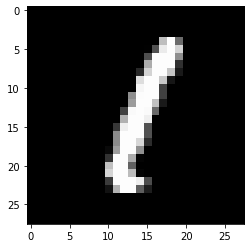

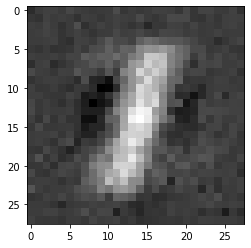

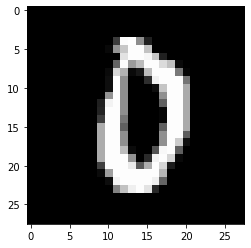

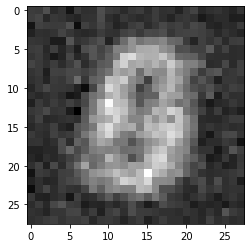

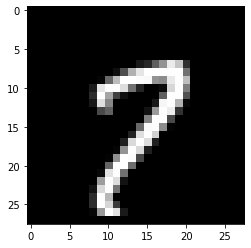

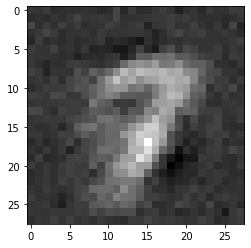

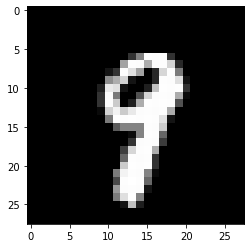

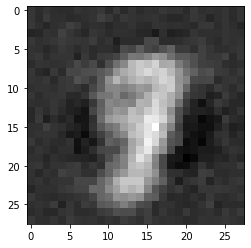

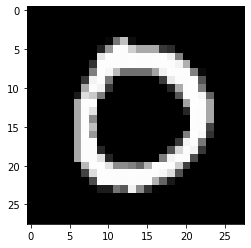

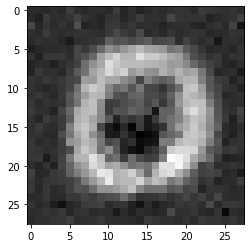

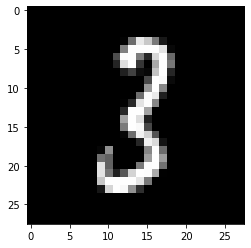

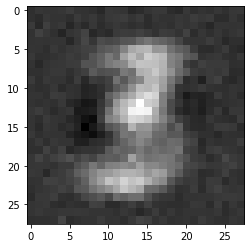

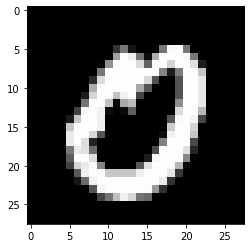

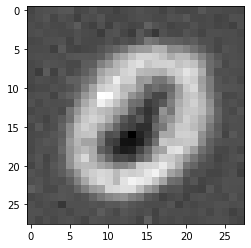

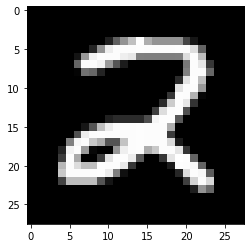

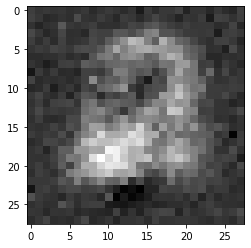

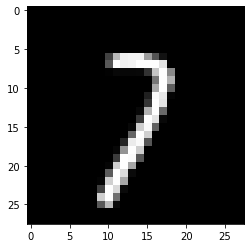

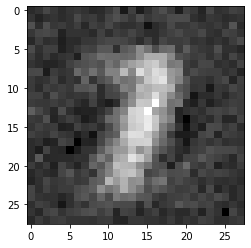

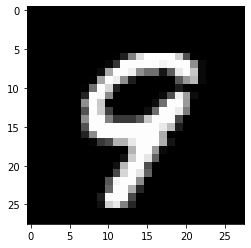

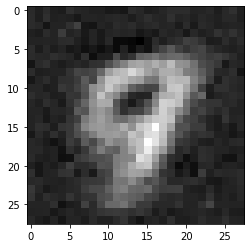

In [7]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## Convolution Transposed Exercise

- torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
- 다양한 세팅에서 전치 컨볼루션 연산이 어떻게 동작하는지 확인

### 1. Import Required Libraries

In [16]:
import torch
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt

print(torch.__version__)

1.9.0


### 2. Input Data

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])


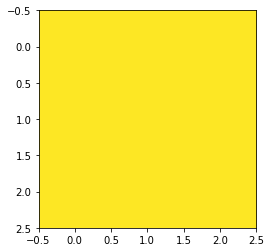

In [17]:
# 입력으로 1로 채워진 텐서를 생성
img = torch.ones(1,1,3,3)
print(img)

plt.imshow(img.numpy()[0,0,...],vmin=0)

### 3.가중치 초기화

In [18]:
transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, output_padding=0, bias=False)
#print(transpose.weight.data)

# 결과를 확인하기 쉽게 전치 컨볼루션 연산의 가중치를 1로 초기화
init.constant_(transpose.weight.data,1)

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

### 4. Kernel Size=3, stride=1, padding=0, output_padding=0

tensor([[[[1., 2., 3., 2., 1.],
          [2., 4., 6., 4., 2.],
          [3., 6., 9., 6., 3.],
          [2., 4., 6., 4., 2.],
          [1., 2., 3., 2., 1.]]]], grad_fn=<SlowConvTranspose2DBackward>) torch.Size([1, 1, 5, 5])


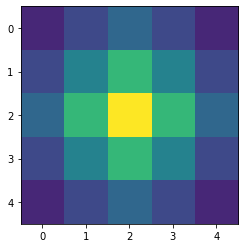

In [19]:
out = transpose(img)
print(out,out.size())

plt.imshow(out.detach().numpy()[0,0,...],vmin=0)
plt.show()

### 5.Kernel Size=3, stride=2, padding=0, output_padding=0

tensor([[[[1., 1., 2., 1., 2., 1., 1.],
          [1., 1., 2., 1., 2., 1., 1.],
          [2., 2., 4., 2., 4., 2., 2.],
          [1., 1., 2., 1., 2., 1., 1.],
          [2., 2., 4., 2., 4., 2., 2.],
          [1., 1., 2., 1., 2., 1., 1.],
          [1., 1., 2., 1., 2., 1., 1.]]]],
       grad_fn=<SlowConvTranspose2DBackward>) torch.Size([1, 1, 7, 7])


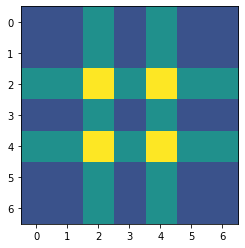

In [20]:
transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0, output_padding=0, bias=False)
init.constant_(transpose.weight.data,1)
out = transpose(img)

print(out,out.size())
plt.imshow(out.detach().numpy()[0,0,...],vmin=0)

### 6.Kernel Size=3, stride=2, padding=1, output_padding=0

tensor([[[[1., 2., 1., 2., 1.],
          [2., 4., 2., 4., 2.],
          [1., 2., 1., 2., 1.],
          [2., 4., 2., 4., 2.],
          [1., 2., 1., 2., 1.]]]], grad_fn=<SlowConvTranspose2DBackward>) torch.Size([1, 1, 5, 5])


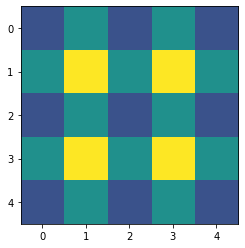

In [21]:
transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=0, bias=False)
init.constant_(transpose.weight.data,1)
out = transpose(img)

print(out,out.size())
plt.imshow(out.detach().numpy()[0,0,...],vmin=0)

### 7. Kernel Size=3, stride=2, padding=0, output_padding=1

tensor([[[[1., 1., 2., 1., 2., 1., 1., 0.],
          [1., 1., 2., 1., 2., 1., 1., 0.],
          [2., 2., 4., 2., 4., 2., 2., 0.],
          [1., 1., 2., 1., 2., 1., 1., 0.],
          [2., 2., 4., 2., 4., 2., 2., 0.],
          [1., 1., 2., 1., 2., 1., 1., 0.],
          [1., 1., 2., 1., 2., 1., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]],
       grad_fn=<SlowConvTranspose2DBackward>) torch.Size([1, 1, 8, 8])


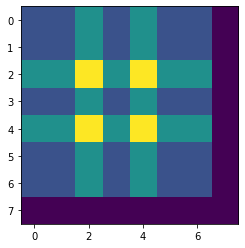

In [22]:
transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0, output_padding=1, bias=False)
init.constant_(transpose.weight.data,1)
out=transpose(img)

print(out,out.size())
plt.imshow(out.detach().numpy()[0,0,...],vmin=0)

### 8. Kernel Size=3, stride=2, padding=1, output_padding=1

tensor([[[[1., 2., 1., 2., 1., 1.],
          [2., 4., 2., 4., 2., 2.],
          [1., 2., 1., 2., 1., 1.],
          [2., 4., 2., 4., 2., 2.],
          [1., 2., 1., 2., 1., 1.],
          [1., 2., 1., 2., 1., 1.]]]], grad_fn=<SlowConvTranspose2DBackward>) torch.Size([1, 1, 6, 6])


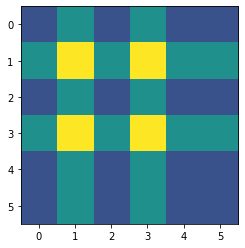

In [23]:
transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
init.constant_(transpose.weight.data,1)

out = transpose(img)
print(out,out.size())
plt.imshow(out.detach().numpy()[0,0,...],vmin=0)

tensor([[[[1., 2., 2., 2., 2., 1.],
          [2., 4., 4., 4., 4., 2.],
          [2., 4., 4., 4., 4., 2.],
          [2., 4., 4., 4., 4., 2.],
          [2., 4., 4., 4., 4., 2.],
          [1., 2., 2., 2., 2., 1.]]]], grad_fn=<SlowConvTranspose2DBackward>) torch.Size([1, 1, 6, 6])


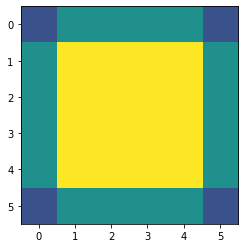

In [24]:
transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False)
init.constant_(transpose.weight.data,1)

out = transpose(img)
print(out,out.size())
plt.imshow(out.detach().numpy()[0,0,...],vmin=0)

## Convolutional Autoencoder
- MNIST dataset
- Convolutional Neural Network
- 2 hidden layers

### 라이브러리 import

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

### 하이퍼파라미터 설정

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

### 데이터 가져오기

In [3]:
mnist_train = dset.MNIST("./data", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./data", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

/Users/adam/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 모델 설계

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),                            # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)                                       # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),                          # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),                         # batch x 64 x 7 x 7
                        nn.ReLU()
        )
                       
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),                    # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),                       # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),                        # batch x 16 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),                       # batch x 1 x 28 x 28
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out


### 모델 생성

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 이를 묶는 방법입니다.
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cpu


### 모델 훈련

In [7]:
# 모델을 불러오는 방법
# 크게 두가지 방법이 있는데 여기 사용된 방법은 좀 단순한 방법
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

try:
    encoder, decoder = torch.load('./data/conv_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        
    if j % 10 == 0:
        # 모델 저장
        # 이 역시 크게 두가지 방법이 있는데 여기 사용된 방법은 좀 단순한 방법
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save([encoder,decoder],'./data/conv_autoencoder.pkl')
        print(loss)



--------model not restored--------



/Users/adam/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### 이미지 확인

torch.Size([256, 28, 28])


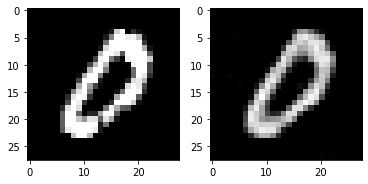

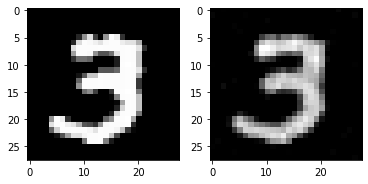

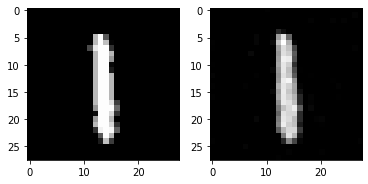

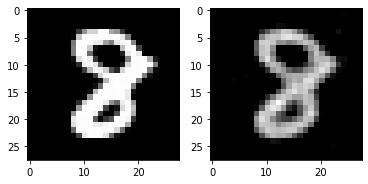

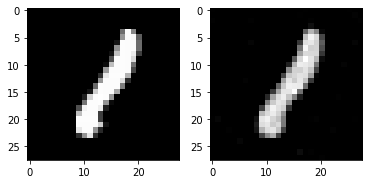

In [8]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

### 역전파를 트래킹 하지 않고 수행

torch.Size([256, 28, 28])


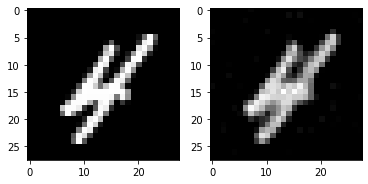

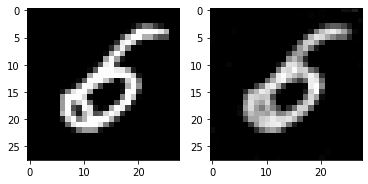

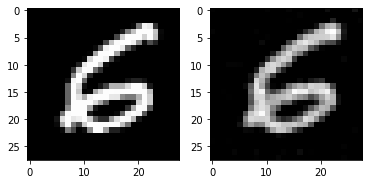

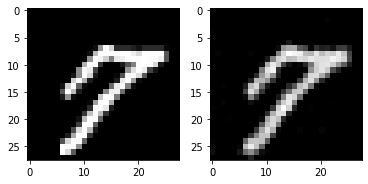

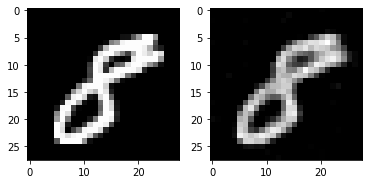

In [9]:
with torch.no_grad():
    for j,[image,label] in enumerate(test_loader):
       
        image = image.to(device)
        output = encoder(image)
        output = decoder(output)
        
    if j % 10 == 0:
        print(loss)   
        
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

### 노이즈 추가

In [10]:
try:
    encoder, decoder = torch.load('./data/conv_autoencoder_noise.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        noise = init.normal_(torch.FloatTensor(batch_size,1,28,28),0,0.1) 
        image = image + noise
        
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        
    if j % 10 == 0:
        # 모델 저장
        # 이 역시 크게 두가지 방법이 있는데 여기 사용된 방법은 좀 단순한 방법
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save([encoder,decoder],'./data/conv_autoencoder_noise.pkl')
        print(loss)



--------model not restored--------



torch.Size([256, 28, 28])


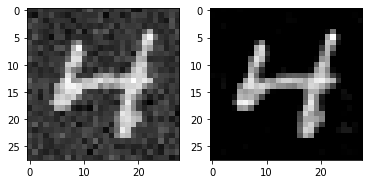

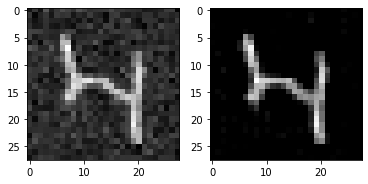

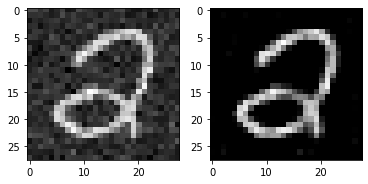

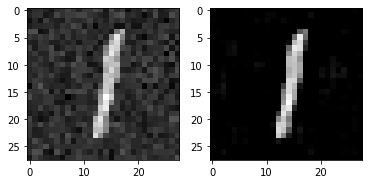

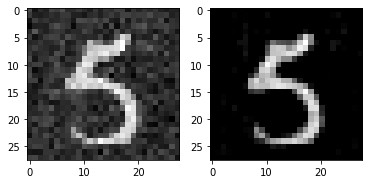

In [11]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## Sementic Segmentation

### 라이브러리 import

In [12]:
import torch.nn as nn
import torch
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms

### 자주 쓰는 연산들과 항상 세트로 쓰는 연산들은 편의를 위해 함수로 정의


In [13]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model   

### 모델 설계

In [14]:
class UnetGenerator(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Tanh(),  #필수는 아님
        )

    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

### 모델 생성

In [15]:
batch_size = 16
img_size = 256
in_dim = 1
out_dim = 3
num_filters = 16

sample_input = torch.ones(size=(batch_size,1,img_size,img_size))

model = UnetGenerator(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters)
output = model(sample_input)
print(output.size())


------Initiating U-Net------

torch.Size([16, 3, 256, 256])


# MNIST GAN

## 일반적인 GAN

### 필요한 라이브러리 설치

In [30]:
!pip install torch torchvision
!pip install pillow==4.1.1

     |████████████████████████████████| 11.3 MB 1.2 MB/s eta 0:00:01
  Created wheel for pillow: filename=Pillow-4.1.1-cp38-cp38-macosx_10_9_x86_64.whl size=446714 sha256=d2459b9416e3dcea52753209d378abfb7aebbd104ffa754b131767dcd42bc8ee
  Stored in directory: /Users/adam/Library/Caches/pip/wheels/5f/7d/2d/ac6d1b3ee8ffb0bfc9bebb84a2a863e7b584de9046e24f67d8
Successfully built pillow
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.2.0
    Uninstalling Pillow-8.2.0:
      Successfully uninstalled Pillow-8.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0 requires pillow>=5.3.0, but you have pillow 4.1.1 which is incompatible.
scikit-image 0.18.1 requires pillow!=7.1.0,!=7.1.1,>=4.3.0, but you have pillow 4.1.1 which is incompatible.
matplotlib 3.3.4 requires pillow>=6.2.0, but you have pillow 4.1.1 which is incompatible.

### 라이브러리 import

In [31]:
import os
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

### 이미지를 늘리는 연산

In [32]:
# 전치 컨볼루션 연산으로 이미지 크기를 2배로 늘리는 방법 2가지
# 둘중에 kernel_size=4,stride=2,padding=1 세팅이 체커보드 아티팩트가 덜합니다.

test = torch.ones(1,1,16,16)
conv1 = nn.ConvTranspose2d(1,1,kernel_size=4,stride=2,padding=1)
out = conv1(test)
print(out.size())

conv1 = nn.ConvTranspose2d(1,1,kernel_size=3,stride=2,padding=1,output_padding=1)
out = conv1(test)
print(out.size())

torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])


### 하이퍼파라미터 설정

In [33]:
epoch = 50
batch_size = 512
learning_rate = 0.0002
num_gpus = 1
z_size = 50
middle_size = 200

### 데이터 다운로드

In [34]:
# Download Data

mnist_train = dset.MNIST("./data", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

### 생성자

In [35]:
# Generator receives random noise z and create 1x28x28 image
# OrderedDict를 사용해 해당 연산의 이름을 지정할 수 있음

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('fc1',nn.Linear(z_size,middle_size)),
                        ('bn1',nn.BatchNorm1d(middle_size)),
                        ('act1',nn.ReLU()),
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
                        ('fc2', nn.Linear(middle_size,784)),
                        #('bn2', nn.BatchNorm1d(784)),
                        ('tanh', nn.Tanh()),
        ]))
    def forward(self,z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = out.view(batch_size,1,28,28)
        return out

### 판별자

In [36]:
# 판별자는 1x28x28 image 를 입력으로 받아서 0~1 을 리턴
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('fc1',nn.Linear(784,middle_size)),
                        #('bn1',nn.BatchNorm1d(middle_size)),
                        ('act1',nn.LeakyReLU()),  
            
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
                        ('fc2', nn.Linear(middle_size,1)),
                        ('bn2', nn.BatchNorm1d(1)),
                        ('act2', nn.Sigmoid()),
        ]))
                                    
    def forward(self,x):
        out = x.view(batch_size, -1)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

### 생성자 와 판별자 생성

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

generator = nn.DataParallel(Generator()).to(device)
discriminator = nn.DataParallel(Discriminator()).to(device)

cpu


### 모듈 구조 확인

In [38]:
gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
    print(i)

module.layer1.fc1.weight
module.layer1.fc1.bias
module.layer1.bn1.weight
module.layer1.bn1.bias
module.layer1.bn1.running_mean
module.layer1.bn1.running_var
module.layer1.bn1.num_batches_tracked
module.layer2.fc2.weight
module.layer2.fc2.bias


### 손실 함수 와 최적화 함수 설정

In [39]:
loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

ones_label = torch.ones(batch_size,1).to(device)
zeros_label = torch.zeros(batch_size,1).to(device)

### 모델 과 결과를 저장할 디렉토리 설정

In [41]:
try:
    generator, discriminator = torch.load('./data/model/vanilla_gan.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass
  
try:
  os.mkdir("./data/model")
except:
  pass

try:
  os.mkdir("./data/result")
except:
  pass


--------model not restored--------



### 모델 훈련

In [42]:
for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        image = image.to(device)
        
        # 구분자 학습
        dis_optim.zero_grad()
      
        # Fake Data 
        # 랜덤한 z를 샘플링해줍니다.
        z = init.normal_(torch.Tensor(batch_size,z_size),mean=0,std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        # Real Data
        dis_real = discriminator.forward(image)
        
        # 두 손실을 더해 최종손실에 대해 기울기 게산을 합니다.
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward(retain_graph=True)
        dis_optim.step()
        
        # 생성자 학습
        gen_optim.zero_grad()
        
        # Fake Data
        z = init.normal_(torch.Tensor(batch_size,z_size),mean=0,std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward()
        gen_optim.step()
    
        # model save
        if j % 100 == 0:
            print(gen_loss,dis_loss)
            torch.save([generator,discriminator],'./data/model/vanilla_gan.pkl')            
            v_utils.save_image(gen_fake.cpu().data[0:25],"./data/result/gen_{}_{}.png".format(i,j), nrow=5)
            print("{}th epoch gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))

tensor(0.2913, grad_fn=<SumBackward0>) tensor(0.5907, grad_fn=<AddBackward0>)
0th epoch gen_loss: 0.2913018763065338 dis_loss: 0.5906564593315125
tensor(0.2958, grad_fn=<SumBackward0>) tensor(0.5307, grad_fn=<AddBackward0>)
0th epoch gen_loss: 0.2957892119884491 dis_loss: 0.5307445526123047
tensor(0.2956, grad_fn=<SumBackward0>) tensor(0.5257, grad_fn=<AddBackward0>)
1th epoch gen_loss: 0.29564908146858215 dis_loss: 0.5256938338279724
tensor(0.2938, grad_fn=<SumBackward0>) tensor(0.4876, grad_fn=<AddBackward0>)
1th epoch gen_loss: 0.2937559485435486 dis_loss: 0.48762136697769165
tensor(0.2918, grad_fn=<SumBackward0>) tensor(0.4933, grad_fn=<AddBackward0>)
2th epoch gen_loss: 0.2918146848678589 dis_loss: 0.49328166246414185
tensor(0.3028, grad_fn=<SumBackward0>) tensor(0.5066, grad_fn=<AddBackward0>)
2th epoch gen_loss: 0.30276942253112793 dis_loss: 0.5066123604774475
tensor(0.2486, grad_fn=<SumBackward0>) tensor(0.5184, grad_fn=<AddBackward0>)
3th epoch gen_loss: 0.24855248630046844 di

### 생성된 이미지 확인

0


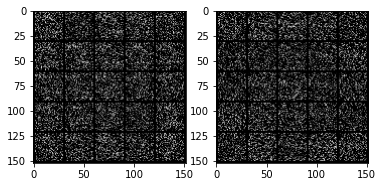

1


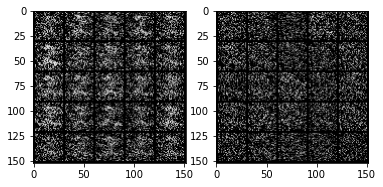

2


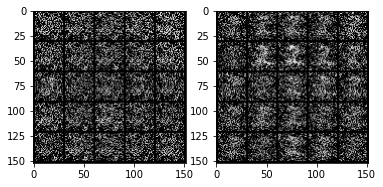

3


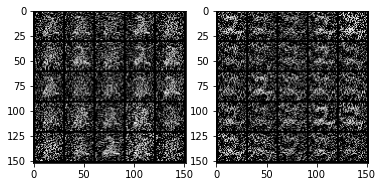

4


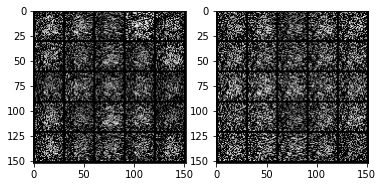

5


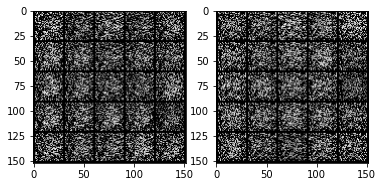

6


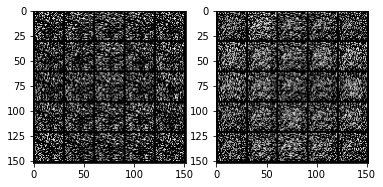

7


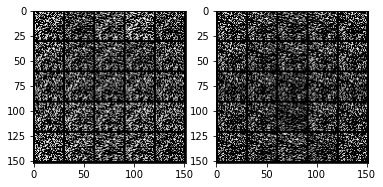

8


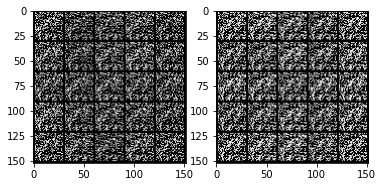

9


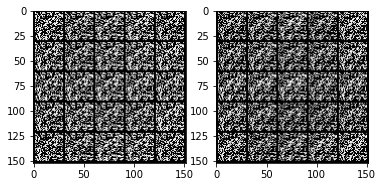

10


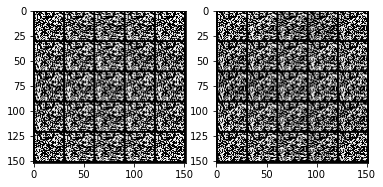

11


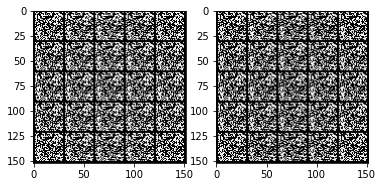

12


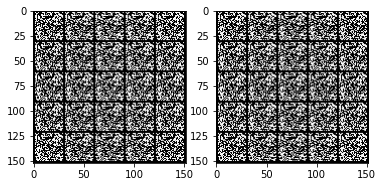

13


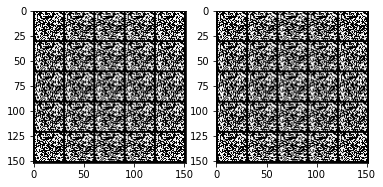

14


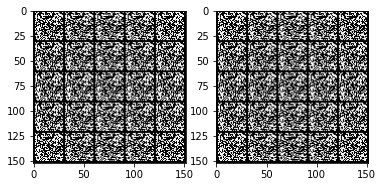

15


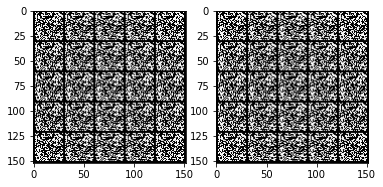

16


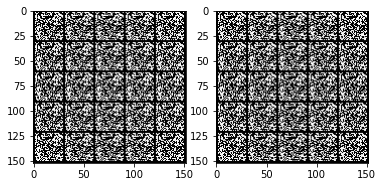

17


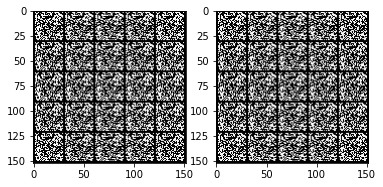

18


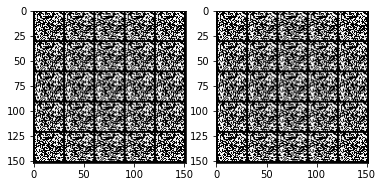

19


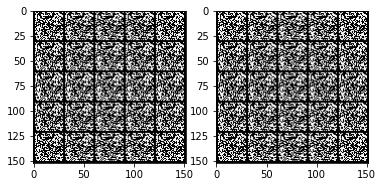

20


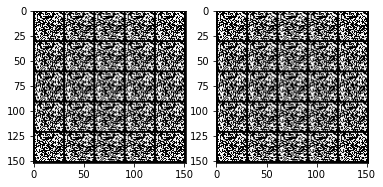

21


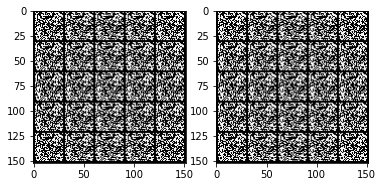

22


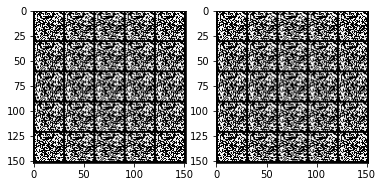

23


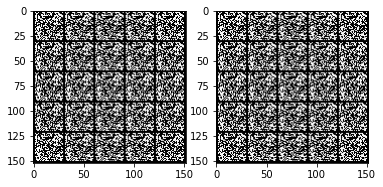

24


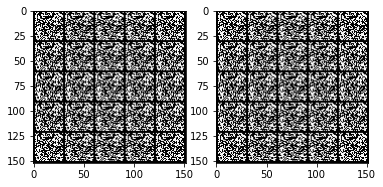

25


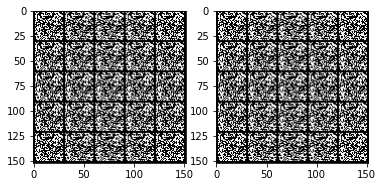

26


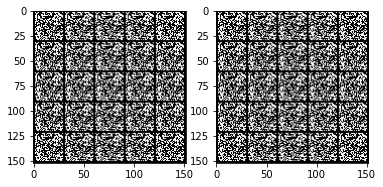

27


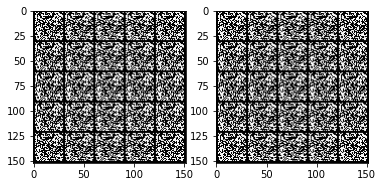

28


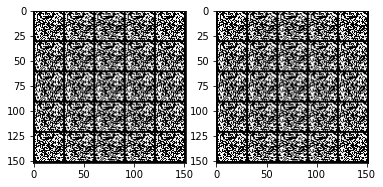

29


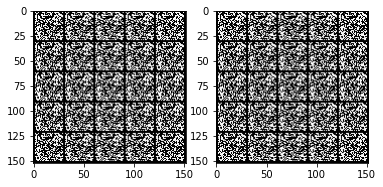

30


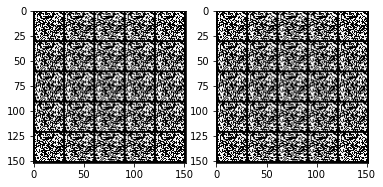

31


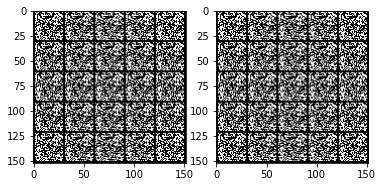

32


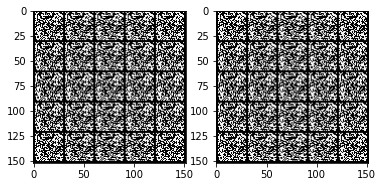

33


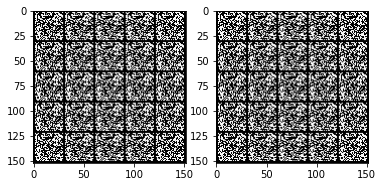

34


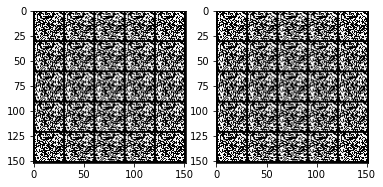

35


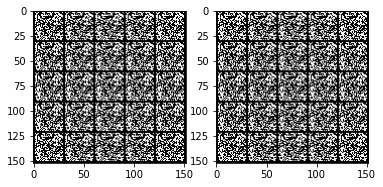

36


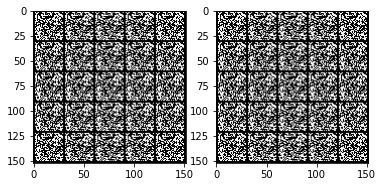

37


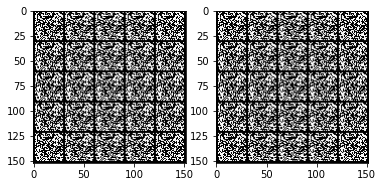

38


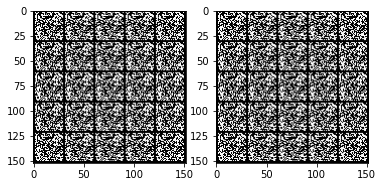

39


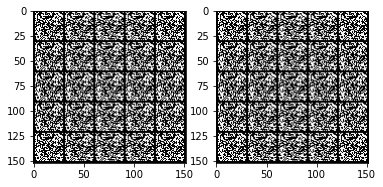

40


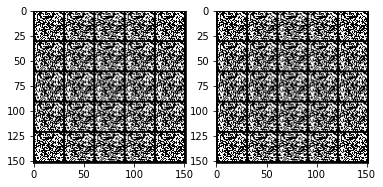

41


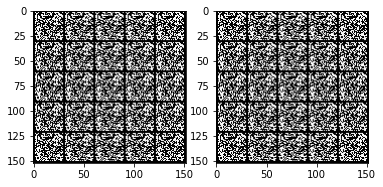

42


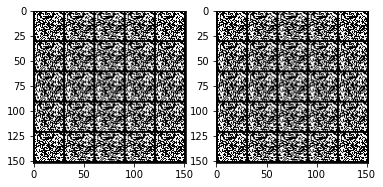

43


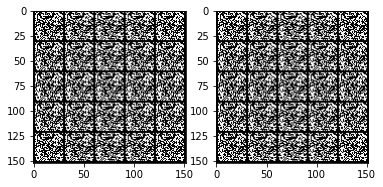

44


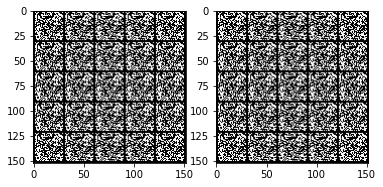

45


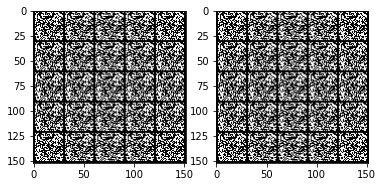

46


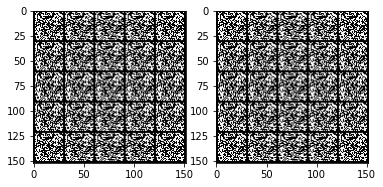

47


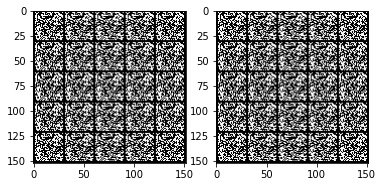

48


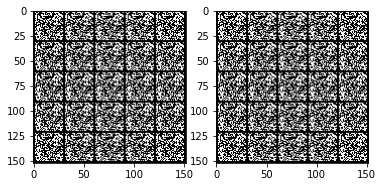

49


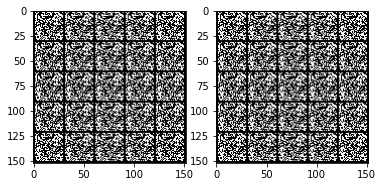

In [44]:
from glob import glob 

for i in range(epoch):
  print(i)
  file_list = glob("./data/result/gen_{}_*.png".format(i))
  img_per_epoch = len(file_list)
  for idx,j in enumerate(file_list):
    img = plt.imread(j)
    plt.subplot(1,img_per_epoch,idx+1)
    plt.imshow(img)
  plt.show()

## DCGAN

### 라이브러리 import

In [45]:
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

### 하이퍼파라미터 설정

In [46]:
epoch = 100
batch_size = 512
learning_rate = 0.0002


### 데이터 가져오기

In [47]:
# Download Data

mnist_train = dset.MNIST("./data", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                        ]),
                        target_transform=None,
                        download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

### 생성자 모델

In [48]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*256),
             nn.BatchNorm1d(7*7*256),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv1', nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1)),     # batch x 128 x 14 x 14
                        ('bn1', nn.BatchNorm2d(128)),
                        ('relu1', nn.ReLU()),
                        ('conv2', nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1)),               # batch x 64 x 14 x 14
                        ('bn2', nn.BatchNorm2d(64)),    
                        ('relu2', nn.ReLU()),
            ]))
        self.layer3 = nn.Sequential(OrderedDict([
                        ('conv3',nn.ConvTranspose2d(64,16,kernel_size=4,stride=2,padding=1)),        # batch x 16 x 28 x 28
                        ('bn3',nn.BatchNorm2d(16)),    
                        ('relu3',nn.ReLU()),
                        ('conv4',nn.Conv2d(16,1,kernel_size=3,stride=1,padding=1)),                  # batch x 1 x 28 x 28
                        ('relu4',nn.Tanh())
            ]))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
        
        
    def forward(self,z):
        out = self.layer1(z)
        out = out.view(batch_size,256,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

### 판별자 모델

In [49]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('conv1',nn.Conv2d(1,8,kernel_size=3,stride=1,padding=1)),   # batch x 8 x 28 x 28
                        #('bn1',nn.BatchNorm2d(8)),    
                        ('relu1',nn.LeakyReLU()),
                        ('conv2',nn.Conv2d(8,16,kernel_size=3,stride=2,padding=1)),  # batch x 16 x 14 x 14
                        ('bn2',nn.BatchNorm2d(16)),    
                        ('relu2',nn.LeakyReLU()),
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv3',nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)), # batch x 32 x 14 x 14
                        ('bn3',nn.BatchNorm2d(32)),
                        ('relu3',nn.LeakyReLU()),
                        ('conv4',nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)), # batch x 64 x 7 x 7
                        ('bn4',nn.BatchNorm2d(64)),
                        ('relu4',nn.LeakyReLU())
        ]))
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)
        return out

### 모델 생성

In [50]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

generator = nn.DataParallel(Generator()).to(device)
discriminator = nn.DataParallel(Discriminator()).to(device)

cpu


### 모델 구조

In [51]:
gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
    print(i)

module.layer1.0.weight
module.layer1.0.bias
module.layer1.1.weight
module.layer1.1.bias
module.layer1.1.running_mean
module.layer1.1.running_var
module.layer1.1.num_batches_tracked
module.layer2.conv1.weight
module.layer2.conv1.bias
module.layer2.bn1.weight
module.layer2.bn1.bias
module.layer2.bn1.running_mean
module.layer2.bn1.running_var
module.layer2.bn1.num_batches_tracked
module.layer2.conv2.weight
module.layer2.conv2.bias
module.layer2.bn2.weight
module.layer2.bn2.bias
module.layer2.bn2.running_mean
module.layer2.bn2.running_var
module.layer2.bn2.num_batches_tracked
module.layer3.conv3.weight
module.layer3.conv3.bias
module.layer3.bn3.weight
module.layer3.bn3.bias
module.layer3.bn3.running_mean
module.layer3.bn3.running_var
module.layer3.bn3.num_batches_tracked
module.layer3.conv4.weight
module.layer3.conv4.bias


### 손실 함수 와 레이블 생성

In [52]:
loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

ones_label = torch.ones(batch_size,1).to(device)
zeros_label = torch.zeros(batch_size,1).to(device)

### 모델 저장 위치 와 결과 저장 위치 설정

In [53]:
# model restore if any

import os

try:
  os.mkdir("./data/model")
except:
  pass

try:
  os.mkdir("./data/result")
except:
  pass

try:
    #generator, discriminator = torch.load('./model/dcgan.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



### 모델 훈련

In [ ]:
# train

for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        image = image.to(device)
        
        # generator
        gen_optim.zero_grad()
        
        z = init.normal_(torch.Tensor(batch_size,100),mean=0,std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward()
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = init.normal_(torch.Tensor(batch_size,100),mean=0,std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        dis_real = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward()
        dis_optim.step()
    
        # model save
        if j % 1000 == 0:
            torch.save([generator,discriminator],'./data/model/dcgan.pkl')
            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            v_utils.save_image(gen_fake.cpu().data[0:25],"./data/result/gen_{}_{}.png".format(i,j), nrow=5)
            
    #image_check(gen_fake.cpu())

0th iteration gen_loss: 0.10985641181468964 dis_loss: 0.9062400460243225
1th iteration gen_loss: 0.7043680548667908 dis_loss: 0.14320705831050873
2th iteration gen_loss: 0.7074041962623596 dis_loss: 0.13165980577468872
3th iteration gen_loss: 0.8401805758476257 dis_loss: 0.04904010519385338
4th iteration gen_loss: 0.8514975905418396 dis_loss: 0.02212582342326641
5th iteration gen_loss: 0.9189774394035339 dis_loss: 0.009037554264068604
6th iteration gen_loss: 0.9668776988983154 dis_loss: 0.002271200530230999
7th iteration gen_loss: 0.9786586761474609 dis_loss: 0.001445915549993515
8th iteration gen_loss: 0.9770386219024658 dis_loss: 0.00166378915309906
9th iteration gen_loss: 0.9764823317527771 dis_loss: 0.0018659747438505292
10th iteration gen_loss: 0.9816930294036865 dis_loss: 0.0025462538469582796
11th iteration gen_loss: 0.9926280975341797 dis_loss: 0.0007384447962976992
12th iteration gen_loss: 0.9957067370414734 dis_loss: 0.0005499557591974735
13th iteration gen_loss: 0.9976846575

### 결과 이미지 확인

In [ ]:
from glob import glob 

for i in range(0,epoch,5):
  print(i)
  file_list = glob("./data/result/gen_{}_*.png".format(i))
  print(file_list)
  
  img_per_epoch = len(file_list)
  
  plt.figure(figsize=(25,5))
  for idx,j in enumerate(file_list):
    img = plt.imread(j)
    plt.subplot(1,img_per_epoch,idx+1)
    plt.imshow(img)
  plt.show()